# 1. Imports and Device Setup

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cpu


## 2. Load Data and Split

In [ ]:
DATA_PATH = 'data/gestures.csv'    #replace with your data path    
MODEL_PATH = 'models/model.pth'    #replace with your model path

In [4]:
# read in data
data = pd.read_csv(DATA_PATH, header = None)
print(f'Full data shape:{data.shape}')

Full data shape:(432, 14)


In [5]:
# Train and test sets
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0, stratify = data[0])

print(f'samples training data:{train_data.shape[0]} | samples test data:{test_data.shape[0]}')

samples training data:345 | samples test data:87


## 3. Create PyTorch Dataset & DataLoader

Define a custom Dataset that returns (features, label) pairs and wrap in DataLoader for batching.

In [6]:
class LandmarkDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        target = torch.tensor(self.df.values[:, 0]).type(torch.LongTensor)
        features = torch.tensor(self.df.values[:, 1:], dtype = torch.float)
        return features[index], target[index]
    
    
train_set = LandmarkDataset(train_data)
test_set = LandmarkDataset(test_data)

In [7]:
b_size = 16
trainloader = DataLoader(train_set, batch_size = b_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = b_size, shuffle = False)

In [10]:
# Quick check
x_batch, y_batch = next(iter(trainloader))
print('Batch shapes:', x_batch.shape, y_batch.shape)

Batch shapes: torch.Size([16, 13]) torch.Size([16])


## 4. Define MLP Model

In [11]:
# Build model
n_features = data.shape[1] - 1
hidden_size = [32, 16]
n_classes = len(data[0].unique())
class MLP(nn.Module):
    def __init__(self, n_features, n_classes, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.output = nn.Linear(hidden_size[1], n_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.output(x), dim = 1)


# Initialize the model
model = MLP(n_features, n_classes, hidden_size)

## 5. Training & Validation Loop

In [12]:
# Model Training/Validation

model.to(device)
learning_rate = 0.001
epochs = 120

optimizer = optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.75
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0
    
    # training
    for x_train_batch, y_train_batch in trainloader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        optimizer.zero_grad()

        # forward pass
        scores = model(x_train_batch)
        train_preds = torch.argmax(scores.detach(), dim=1)

        # loss
        train_loss = criterion(scores, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        
        train_loss.backward()
        
        # update paramaters
        
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            x_test_batch = x_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)
            # logits
            test_scores = model(
                x_test_batch)

            # predictions
            test_preds = torch.argmax(test_scores, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()

            # loss
            test_loss = criterion(test_scores, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_loss / len(testloader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.to('cpu').state_dict(), MODEL_PATH)
            
            # bring back to gpu
            model.to(device) 

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()




Epoch 1/120
Train loss: 2.5635
Test accuracy: 12.50%
Epoch 2/120
Train loss: 2.5605
Test accuracy: 15.62%
Epoch 3/120
Train loss: 2.5563
Test accuracy: 21.88%
Epoch 4/120
Train loss: 2.5482
Test accuracy: 22.92%
Epoch 5/120
Train loss: 2.5340
Test accuracy: 28.12%
Epoch 6/120
Train loss: 2.5091
Test accuracy: 30.21%
Epoch 7/120
Train loss: 2.4752
Test accuracy: 25.00%
Epoch 8/120
Train loss: 2.4389
Test accuracy: 22.92%
Epoch 9/120
Train loss: 2.4056
Test accuracy: 28.12%
Epoch 10/120
Train loss: 2.3666
Test accuracy: 33.63%
Epoch 11/120
Train loss: 2.3322
Test accuracy: 45.39%
Epoch 12/120
Train loss: 2.2946
Test accuracy: 51.64%
Epoch 13/120
Train loss: 2.2489
Test accuracy: 69.94%
Epoch 14/120
Train loss: 2.2049
Test accuracy: 66.82%
Epoch 15/120
Train loss: 2.1667
Test accuracy: 70.24%
Epoch 16/120
Train loss: 2.1382
Test accuracy: 70.24%
Epoch 17/120
Train loss: 2.1060
Test accuracy: 75.74%
Epoch 18/120
Train loss: 2.0806
Test accuracy: 75.74%
Epoch 19/120
Train loss: 2.0548
Test 

## 6. Loss & Accuracy Curves

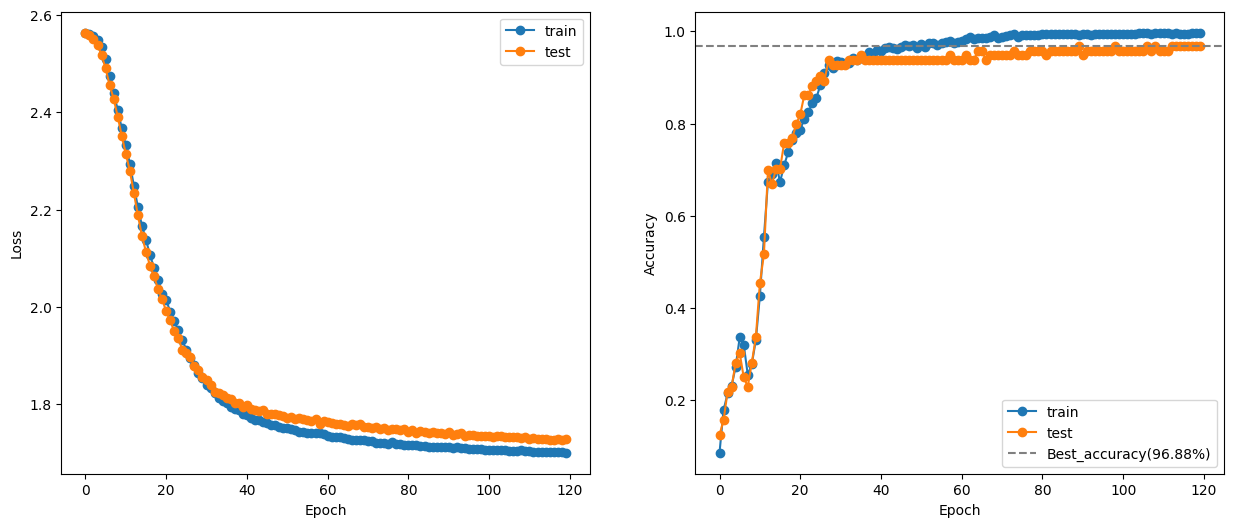

In [13]:
# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 7. Detailed Evaluation

In [15]:
# Load best model
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device).eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for Xv, yv in testloader:
        Xv = Xv.to(device)
        logits = model(Xv)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yv.numpy())


In [18]:
# Metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec  = recall_score(all_labels, all_preds, average='weighted')
f1   = f1_score(all_labels, all_preds, average='weighted')
print(f"Overall Accuracy : {acc*100: .2f}%")
print(f"Weighted Precision: {prec*100: .2f}%")
print(f"Weighted Recall   : {rec*100: .2f}%")
print(f"Weighted F1-Score : {f1*100: .2f}%")

Overall Accuracy :  96.55%
Weighted Precision:  97.02%
Weighted Recall   :  96.55%
Weighted F1-Score :  96.45%


<Figure size 800x800 with 0 Axes>

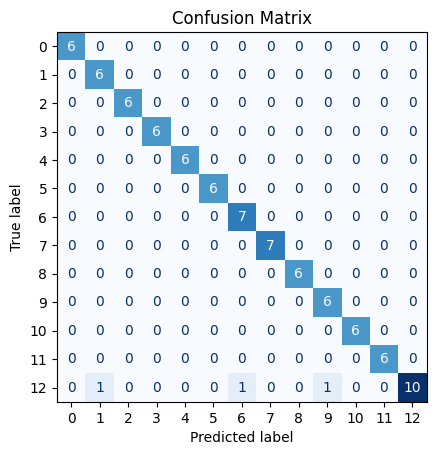

In [19]:
# Confusion Matrix
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds, cmap='Blues', colorbar=False
)
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(
    all_labels, all_preds, target_names=[
        'Cap_Subt','Play_Pause','fullscreen','Vol_up_ytb','Vol_up_gen',
        'Vol_down_ytb','Vol_down_gen','Forward','Backward','Move_mouse',
        'Left_click','Right_click','Neutral'
    ], zero_division=0
))


Classification Report:

              precision    recall  f1-score   support

    Cap_Subt       1.00      1.00      1.00         6
  Play_Pause       0.86      1.00      0.92         6
  fullscreen       1.00      1.00      1.00         6
  Vol_up_ytb       1.00      1.00      1.00         6
  Vol_up_gen       1.00      1.00      1.00         6
Vol_down_ytb       1.00      1.00      1.00         6
Vol_down_gen       0.88      1.00      0.93         7
     Forward       1.00      1.00      1.00         7
    Backward       1.00      1.00      1.00         6
  Move_mouse       0.86      1.00      0.92         6
  Left_click       1.00      1.00      1.00         6
 Right_click       1.00      1.00      1.00         6
     Neutral       1.00      0.77      0.87        13

    accuracy                           0.97        87
   macro avg       0.97      0.98      0.97        87
weighted avg       0.97      0.97      0.96        87

